In [14]:
import sys
from termcolor import colored, cprint
import numpy as np
import tensorflow as tf
from pde_model import Lorenz_Model
from dataset import dataset, dataset_sphere
from utils import *

def lr(epoch):
    learning_rate = 1e-3
    if epoch > 120:
        return (1e-4)
    elif epoch > 80:
        return (5e-4)
    return learning_rate




configs = {'n_samples': 1024, 'batch_size': 256, 'sub_nx': 16, 'sub_nz': 16, 
           'patch_x': 1, 'patch_z': 1, 'min_patch_x': 0.1, 'min_patch_z': 0.1,
           'xmin': -20, 'xmax': 20, 'zmin': 0, 'zmax': 40, 'sigma': 10, 'beta': 2.67, 'gamma': 28, 
           'epochs': 256, 'epsilon': 0.1, 'R':5, 
           'db_save_path': '/Users/xiaohan.zhang/Planet/Codes/axiom/python/lorenz/data/',
           'LOG_DIR': '/Users/xiaohan.zhang/Planet/Codes/axiom/python/lorenz/log_tb/',
           'restore': False}

if 1:
    
    model = Lorenz_Model(**configs)
    
    tol = 1e-9 # convergence tol
    epochs = configs['epochs']
    LOG_DIR = configs['LOG_DIR']

    """ Optimization setup
    """

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    if configs['restore']:
        print('Restore saved model for reuse')
        saver = tf.train.Saver()
        saver.restore(sess, save_path=os.path.join(configs['LOG_DIR'], "model.ckpt-0"))

    refine_factor = 0.5

    kargs = configs.copy()
    args = configs.copy()
    Nx, Nz = 8, 8
    region_x = (configs['xmax']-configs['xmin'])/Nx * 2
    region_z = (configs['zmax']-configs['zmin'])/Nz * 2

    print('region_x = {0}'.format(region_x))
#     r_linspace = .5* np.linspace( 5, np.max([args['xmax']-args['xmin'], args['zmax']-args['zmin']]), 3)
    
    r_linspace = [5, 10,20,40]
    center = .5*(args['xmax']+args['xmin']), .5*(args['zmax']+args['zmin'])
#     z_linspace = np.linspace(args['zmin'], args['zmax'], Nz)

#     for x0 in x_linspace:
#         for z0 in z_linspace:
    for ind, RR in enumerate(r_linspace):
        if 1:
#             xmin = x0 - region_x/2.0
#             xmax = x0 + region_x/2.0
#             zmin = z0 - region_z/2.0
#             zmax = z0 + region_z/2.0
#             xmin,xmax,zmin,zmax = configs['xmin'],configs['xmax'],configs['zmin'],configs['zmax']

#             kargs['xmin'], kargs['xmax'] = xmin, xmax
#             kargs['zmin'], kargs['zmax'] = zmin, zmax

            kargs['center'] = center
            kargs['R'] = RR
            if ind == 0:
                kargs['R0'] = 0
            else:
                kargs['R0'] = r_linspace[ind-1]
            kargs['n_samples'] = kargs['n_samples'] *4
            
            db = dataset_sphere(reuse = False, **kargs)
    
            inds = np.arange(db.shape[0])

            for epoch in range(epochs):

                np.random.shuffle(inds)

                for index, ind in enumerate(inds):
                    result = sess.run([model.op, model.loss_sum, model.G], feed_dict={model.x_ph:db[ind], model.learning_rate:lr(epoch)})
                    #if index == 0 or index % 100 == 0:
                    #    print("Index = {:5d}; Residuals={: 5.10E};".format(index, result[1]))

                if epoch % 1 == 0:
                    print("Epoch = {:5d}; LR = {:5.10E}; Residuals={: 5.10E};".format(epoch, lr(epoch), result[1]))

                if np.abs(result[1]) < 1e-3:
                    cprint("Converged in {:d} epochs!!!".format(epoch), 'green', 'on_red')
                    print("Residual={: 5.10E}.".format(result[1]))
                    break

            cprint("Failed to converged in {:d} epochs!!!".format(epoch), 'green', 'on_red')


    step = 0
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), step)




xadv, G and dG shape
(?, 2)
(?, 1)
(?, 2)
(?, 1)
()
done
region_x = 10.0
R= 5, Cx = 0.0, Cz = 20.0, batchsize = 256
Epoch =     0; LR = 1.0000000000E-03; Residuals= 1.0558728945E-02;
Epoch =     1; LR = 1.0000000000E-03; Residuals= 4.0386320519E-03;
Epoch =     2; LR = 1.0000000000E-03; Residuals= 3.6187023785E-03;
Epoch =     3; LR = 1.0000000000E-03; Residuals= 1.1358696063E-03;
Epoch =     4; LR = 1.0000000000E-03; Residuals= 9.7933727241E-04;
Converged in 4 epochs!!!
Residual= 9.7933727241E-04.
Failed to converged in 4 epochs!!!
R= 10, Cx = 0.0, Cz = 20.0, batchsize = 256
Epoch =     0; LR = 1.0000000000E-03; Residuals= 2.6136371521E-03;
Epoch =     1; LR = 1.0000000000E-03; Residuals= 8.6120539199E-04;
Converged in 1 epochs!!!
Residual= 8.6120539199E-04.
Failed to converged in 1 epochs!!!
R= 20, Cx = 0.0, Cz = 20.0, batchsize = 256
Epoch =     0; LR = 1.0000000000E-03; Residuals= 1.5843119761E-04;
Converged in 0 epochs!!!
Residual= 1.5843119761E-04.
Failed to converged in 0 epochs

In [6]:
db[0][1]

array([ 2.92209526, 18.49781342])

In [12]:
# for ti in range(N):
N = 1000
ti = 0
coarse_traj = np.zeros((N,3))
sigma = configs['sigma']
beta = configs['beta']
gamma = configs['gamma']
dt = 0.0001
xi,zi =1.03248107, 20.13403712

for ti in range(N):
#     xi, zi = 0, 5
    coarse_traj[ti] = [xi, 0, zi]
    test_input = np.array([xi,zi]).reshape(1,-1)
    loss_sum_val = sess.run([model.loss_sum], feed_dict={model.x_ph:test_input})
    print('test output of loss_sum = {0}'.format(loss_sum_val))
    y0 = sess.run([model.G], feed_dict={model.x_ph:test_input})
    yi = y0[0]
    print('test output of G = {0}'.format(yi))
    print('xi = {0}, zi = {1}'.format(xi,zi))

    xdot = sigma*(yi-xi)
    zdot = xi*yi - beta*zi
    xi = xi + xdot * dt
    zi = zi + zdot * dt

test output of loss_sum = [0.0002956842067028888]
test output of G = [[-0.68464433]]
xi = 1.03248107, zi = 20.13403712
test output of loss_sum = [0.0002950321689324478]
test output of G = [[-0.68376507]]
xi = [[1.03076394]], zi = [[20.12859064]]
test output of loss_sum = [0.00029435911119978875]
test output of G = [[-0.68288669]]
xi = [[1.02904942]], zi = [[20.12314583]]
test output of loss_sum = [0.00029366519498218255]
test output of G = [[-0.68200919]]
xi = [[1.02733748]], zi = [[20.11770268]]
test output of loss_sum = [0.00029295058442083523]
test output of G = [[-0.68113256]]
xi = [[1.02562813]], zi = [[20.11226119]]
test output of loss_sum = [0.0002922154462760445]
test output of G = [[-0.6802568]]
xi = [[1.02392137]], zi = [[20.10682135]]
test output of loss_sum = [0.0002914599498835762]
test output of G = [[-0.67938193]]
xi = [[1.02221719]], zi = [[20.10138318]]
test output of loss_sum = [0.0002906842671071692]
test output of G = [[-0.67850792]]
xi = [[1.02051559]], zi = [[20.0

test output of loss_sum = [6.881408381274621e-05]
test output of G = [[-0.55643883]]
xi = [[0.79122806]], zi = [[19.29349822]]
test output of loss_sum = [6.748609637109747e-05]
test output of G = [[-0.55569486]]
xi = [[0.78988039]], zi = [[19.28830283]]
test output of loss_sum = [6.616898330954792e-05]
test output of G = [[-0.55495173]]
xi = [[0.78853482]], zi = [[19.28310896]]
test output of loss_sum = [6.486285648093334e-05]
test output of G = [[-0.55420942]]
xi = [[0.78719133]], zi = [[19.27791661]]
test output of loss_sum = [6.356782567643634e-05]
test output of G = [[-0.55346794]]
xi = [[0.78584993]], zi = [[19.27272578]]
test output of loss_sum = [6.228399862248292e-05]
test output of G = [[-0.55272729]]
xi = [[0.78451061]], zi = [[19.26753647]]
test output of loss_sum = [6.10114809794079e-05]
test output of G = [[-0.55198747]]
xi = [[0.78317337]], zi = [[19.26234867]]
test output of loss_sum = [5.9750376338874156e-05]
test output of G = [[-0.55124848]]
xi = [[0.78183821]], zi = 

test output of loss_sum = [3.0144183710308598e-05]
test output of G = [[-0.43728472]]
xi = [[0.58274388]], zi = [[18.39693214]]
test output of loss_sum = [3.0852429711411496e-05]
test output of G = [[-0.43668064]]
xi = [[0.58172385]], zi = [[18.39199467]]
test output of loss_sum = [3.156612854074439e-05]
test output of G = [[-0.43607731]]
xi = [[0.58070545]], zi = [[18.38705861]]
test output of loss_sum = [3.228517506044975e-05]
test output of G = [[-0.43547473]]
xi = [[0.57968867]], zi = [[18.38212394]]
test output of loss_sum = [3.300946417402945e-05]
test output of G = [[-0.43487289]]
xi = [[0.5786735]], zi = [[18.37719067]]
test output of loss_sum = [3.373889084042758e-05]
test output of G = [[-0.43427179]]
xi = [[0.57765996]], zi = [[18.37225879]]
test output of loss_sum = [3.447335008558478e-05]
test output of G = [[-0.43367145]]
xi = [[0.57664802]], zi = [[18.36732831]]
test output of loss_sum = [3.5212737015173935e-05]
test output of G = [[-0.43307184]]
xi = [[0.5756377]], zi =

test output of G = [[-0.33295556]]
xi = [[0.41183691]], zi = [[17.4598717]]
test output of loss_sum = [0.00016654049387966401]
test output of G = [[-0.33248677]]
xi = [[0.41109212]], zi = [[17.4551962]]
test output of loss_sum = [0.00016685745413001296]
test output of G = [[-0.33201862]]
xi = [[0.41034854]], zi = [[17.450522]]
test output of loss_sum = [0.00016716902406791178]
test output of G = [[-0.33155111]]
xi = [[0.40960617]], zi = [[17.44584908]]
test output of loss_sum = [0.00016747521247068286]
test output of G = [[-0.33108424]]
xi = [[0.40886501]], zi = [[17.44117746]]
test output of loss_sum = [0.0001677760286352981]
test output of G = [[-0.330618]]
xi = [[0.40812506]], zi = [[17.43650713]]
test output of loss_sum = [0.00016807148237470807]
test output of G = [[-0.33015241]]
xi = [[0.40738632]], zi = [[17.43183809]]
test output of loss_sum = [0.00016836158401279365]
test output of G = [[-0.32968744]]
xi = [[0.40664878]], zi = [[17.42717034]]
test output of loss_sum = [0.00016

test output of G = [[-0.25867776]]
xi = [[0.29620853]], zi = [[16.64311486]]
test output of loss_sum = [0.00016023361109723417]
test output of G = [[-0.25831415]]
xi = [[0.29565364]], zi = [[16.63866349]]
test output of loss_sum = [0.000160019081777909]
test output of G = [[-0.25795107]]
xi = [[0.29509967]], zi = [[16.63421333]]
test output of loss_sum = [0.00015980470561558044]
test output of G = [[-0.25758853]]
xi = [[0.29454662]], zi = [[16.62976438]]
test output of loss_sum = [0.00015959051612959223]
test output of G = [[-0.25722652]]
xi = [[0.29399449]], zi = [[16.62531665]]
test output of loss_sum = [0.00015937654673194785]
test output of G = [[-0.25686505]]
xi = [[0.29344327]], zi = [[16.62087013]]
test output of loss_sum = [0.00015916283072679293]
test output of G = [[-0.25650411]]
xi = [[0.29289296]], zi = [[16.61642482]]
test output of loss_sum = [0.0001589494013100134]
test output of G = [[-0.2561437]]
xi = [[0.29234356]], zi = [[16.61198072]]
test output of loss_sum = [0.00

test output of loss_sum = [0.00014866019959650868]
test output of G = [[-0.20552077]]
xi = [[0.21606854]], zi = [[15.92477129]]
test output of loss_sum = [0.00014886186194195818]
test output of G = [[-0.20523804]]
xi = [[0.21564695]], zi = [[15.92051494]]
test output of loss_sum = [0.00014906843657930765]
test output of G = [[-0.20495576]]
xi = [[0.21522606]], zi = [[15.91625973]]
test output of loss_sum = [0.00014927995760932101]
test output of G = [[-0.20467392]]
xi = [[0.21480588]], zi = [[15.91200568]]
test output of loss_sum = [0.00014949645936011022]
test output of G = [[-0.20439252]]
xi = [[0.2143864]], zi = [[15.90775278]]
test output of loss_sum = [0.00014971797638923384]
test output of G = [[-0.20411156]]
xi = [[0.21396762]], zi = [[15.90350103]]
test output of loss_sum = [0.00014994454348973843]
test output of G = [[-0.20383105]]
xi = [[0.21354954]], zi = [[15.89925042]]
test output of loss_sum = [0.00015017619569142348]
test output of G = [[-0.20355098]]
xi = [[0.21313216]]

In [15]:
db = np.load('data/open_cover_sphere_R_5_Cx_0.0_Cz_20.0_batchsize_256_nsamples_4096.npy')

In [13]:
def list_scatter3d_plotly(trajs): # Plot footprints of a point trajectory
    # traj has format
    # [ x0,y0,z0; 
    #   x1,y1,z1; 
    #   ...
    #   xN,yN,zN] 
    import plotly
    import plotly.graph_objs as go
    plotly.offline.init_notebook_mode(connected=True)
    
    colorscales = ['Blues', 'Viridis']
    data = []
    for index, traj in enumerate(trajs):
        x, y, z = traj[::5,0], traj[::5,1], traj[::5,2]
        trace1 = go.Scatter3d(x=x,y=y,z=z,mode='markers',
            marker=dict(size=2, color=z, # set color to an array/list of desired values
                colorscale=colorscales[index],   # choose a colorscale
                opacity=0.8))
        data.append(trace1)
    layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename='lorenz.html')
list_scatter3d_plotly([coarse_traj])

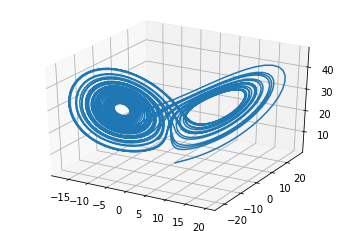

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(f, state0, t)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(states[:,0], states[:,1], states[:,2])


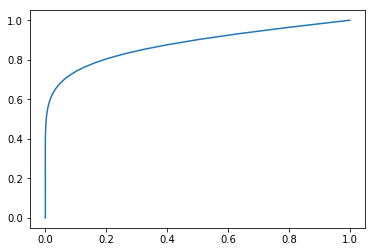

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, tmp, z = state  # unpack the state vector
    test_input = np.array([x,z]).reshape(1,-1)
    y0 = sess.run([model.G], feed_dict={model.x_ph:test_input})
    y = y0[0]
    return sigma * (y - x), 0, x * y - beta * z  # derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(f, state0, t)

fig = plt.figure()
# ax = fig.gca(projection='2d')
plt.plot(states[:,0], states[:,2])
